<a href="https://colab.research.google.com/github/dsuwala/cmpp/blob/main/cmpp6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [ ]:
#spell to have animations working
from matplotlib import rc
rc('animation', html='jshtml', embed_limit='4096')

# Dataset

In [ ]:
zero = np.array([  
                    -1, 1, 1, 1, -1,
                    1, -1, -1, -1, 1,
                    1, -1, -1, -1, 1,
                    1, -1, -1, -1, 1,
                    1, -1, -1, -1, 1,
                    -1, 1, 1, 1, -1  
                  ])

one = np.array([
                -1, 1, 1, -1, -1,
                -1, -1, 1, -1, -1,
                -1, -1, 1, -1, -1,
                -1, -1, 1, -1, -1,
                -1, -1, 1, -1, -1,
                -1, -1, 1, -1, -1
                ])

two = np.array([
                    1, 1, 1, -1, -1,
                    -1, -1, -1, 1, -1,
                    -1, -1, -1, 1, -1,
                    -1, 1, 1, -1, -1,
                    1, -1, -1, -1, -1,
                    1, 1, 1, 1, 1
                 ]) 

In [ ]:
noisy0 =np.array([
                -1, 1, 1, 1, -1,
                1, -1, -1, -1, -1,
                1, -1, -1, -1, 1,
                -1, -1, -1, -1, -1,
                -1, -1, -1, -1, -1,
                -1, -1, 1, -1, -1,
                ])

noisy2 = np.array([
                1, 1, 1, -1, -1,
                -1, -1, -1, -1, -1,
                -1, -1, -1, -1, -1,
                -1, -1, 1, -1, -1,
                1, -1, -1, -1, -1,
                1, 1, -1, -1, 1,
                ])
noisy2b = np.array([
                1, 1, 1, -1, -1,
                -1, -1, -1, 1, -1,
                -1, -1, -1, 1, -1,
                -1, -1, -1, -1, -1,
                -1, -1, -1, -1, -1,
                -1, -1, -1, -1, -1,
                ])

In [ ]:
train_set = [zero, one, two]
test_set = [noisy0, noisy2, noisy2b]

# Task 1

In [ ]:
def training(training_set: list, epochs: int):

    w = np.zeros(shape=(training_set[1].shape[0], 
                        training_set[1].shape[0]))

    # init state
    x = np.ones(shape=training_set[0].shape[0])

    for step in range(epochs):
        energy = np.zeros(shape=training_set[1].shape[0])

        for sample in training_set:
            w += np.tensordot(sample, sample, axes=0)

        w = (w / len(training_set)) - np.identity(w.shape[0])

        h = w@x

        for idx, value in enumerate(x):

            energy[idx] += -0.5 * value * h[idx]
            
        x = np.sign(np.dot(w, x))

    return w

In [ ]:
def evolve(x: np.ndarray, w: np.ndarray, steps: int):

    # (state, energy) history
    history = []

    for step in range(steps):
        energy = np.zeros(shape=x.shape[0])

        h = w@x

        for idx, value in enumerate(x):

            energy[idx] += -0.5 * value * h[idx]

        history.append((x.copy(), energy.sum()))

        x = np.sign(np.dot(w, x))
        

    return history

In [ ]:
w = training(train_set, 5)

global_history = []
for exp in test_set:
    global_history.append(evolve(exp.copy(), w, 10))

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
exp_names = ["noisy0", "noisy2", "noisy2b"]

def animate(i):

    exp_num = 0

    for nrow in range(2):
        for ncol in range(2):

            ax[nrow, ncol].clear()
            ax[nrow, ncol].set_title(f"{exp_names[exp_num]}, step {i}")
            ax[nrow, ncol].imshow(global_history[exp_num][i][0].reshape(6, 5), cmap="binary")

            if exp_num != 2:
                exp_num += 1
            else:
                break


    

anim = FuncAnimation(fig, animate, frames=10, interval=100)
plt.close()
anim

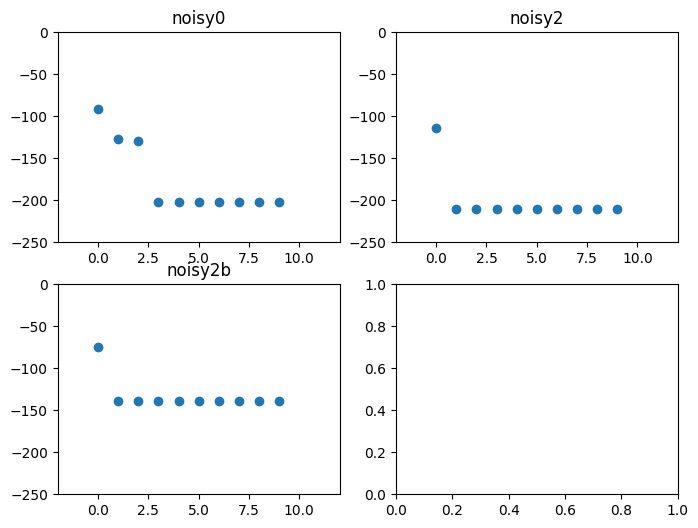

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

exp_num = 0

for nrow in range(2):
    for ncol in range(2):

        ax[nrow, ncol].clear()
        ax[nrow, ncol].set_ylim(-250, 0)
        ax[nrow, ncol].set_xlim(-2, 12)
        ax[nrow, ncol].set_title(f"{exp_names[exp_num]}")
        ax[nrow, ncol].scatter(range(10), [global_history[exp_num][i][1] for i in range(10)])

        if exp_num != 2:
            exp_num += 1
        else:
            break

# Task 2

In [ ]:
def async_update(x: np.ndarray, w: np.ndarray):

    xh = np.dot(w, x.copy())

    # loop over input_state, randomly checking spins
    for i in range(x.shape[0]):

        idx = np.random.randint(0, x.shape[0], size=None)
        energy_correction = - 0.5 * np.sign(xh[idx]) * xh[idx]

    
        if  energy_correction < 0:
            x[idx] = np.sign(xh[idx])
 
            xh = np.dot(w, x.copy())
         

    return x

In [ ]:
def evolve(x: np.ndarray, w: np.ndarray, steps: int):

    # (state, energy) history
    history = []
    history.append((x.copy(), 0))


    for step in range(steps):

        h = np.dot(w, x)
        
        
        # calculate energy of current spin confoguration
        energy = np.zeros(shape=x.shape[0], dtype=float)
        for idx, value in enumerate(x):
    
            energy[idx] += -0.5 * value * h[idx]


        # randomly update spins if it leads to energy decrease
        x = async_update(x, w)

        history.append((x.copy(), energy.sum()))


    return history

In [ ]:
def training(training_set: list, epochs: int):

    w = np.zeros(shape=(training_set[1].shape[0], 
                        training_set[1].shape[0]), dtype=float)

    # init state
    x = np.ones(shape=training_set[0].shape[0])

    for sample in training_set:
        w += np.tensordot(sample, sample, axes=0)

    w = (w / len(training_set)) - np.identity(w.shape[0])


    return w

In [ ]:
N = 15
w = training(train_set, 3)
history = evolve(noisy2b.copy(), w, N)

# print([f"{h[0].reshape(6, 5)}" for h in history])

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

def animate(i):

    ax.clear()
    ax.set_title(f"step {i}")
    ax.imshow(history[i][0].reshape(6, 5), cmap="binary")

anim = FuncAnimation(fig, animate, frames=N, interval=100)
plt.close()
anim

In [ ]:
print([f"{h[1]}" for h in history])

['0', '-50.33333333333333', '-92.33333333333333', '-119.0', '-141.0', '-141.0', '-141.0', '-141.0', '-141.0', '-141.0', '-141.0', '-141.0', '-141.0', '-141.0', '-141.0', '-141.0']


Text(0.5, 1.0, 'noisy2b')

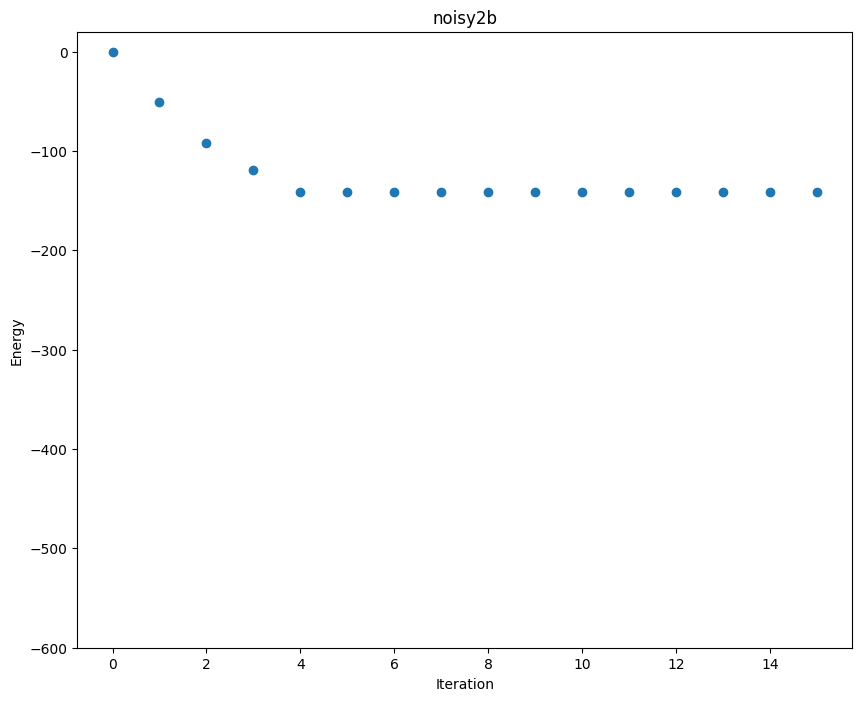

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(range(N+1), [h[1] for h in history])
ax.set_ylim(-600, 20)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy")
ax.set_title("noisy2b")

# Extra

In [ ]:
three = np.array([
                    1, 1, 1, -1, -1,
                    -1, -1, 1, -1, -1,
                    -1, -1, 1, -1, -1,
                    1, 1, 1, -1, -1,
                    -1, -1, 1, -1, -1,
                    1, 1, 1, -1, -1,
                  ])


four = np.array([  
                    -1, -1, 1, -1, -1,
                    -1, 1, 1, -1, -1,
                    1, -1, 1, -1, -1,
                    1, 1, 1, 1, -1,
                    -1, -1, 1, -1, -1,
                    -1, -1, 1, -1, -1  
                  ])

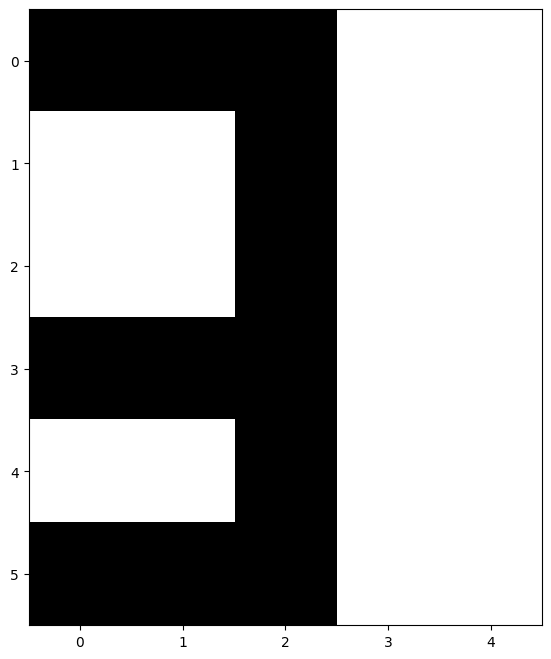

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.imshow(three.reshape(6, 5), cmap="binary")

In [ ]:
train_set = [zero, one, two, three, four]
test_set = [noisy0, noisy2, noisy2b]

In [ ]:
def training(training_set: list, epochs: int):

    w = np.zeros(shape=(training_set[1].shape[0], 
                        training_set[1].shape[0]))
    energy = np.zeros(shape=training_set[1].shape[0])

    # init state
    x = np.ones(shape=training_set[0].shape[0])

    for step in range(epochs):

        for sample in training_set:
            w += np.tensordot(sample, sample, axes=0)

        w = (w / len(training_set)) - np.identity(w.shape[0])

        h = w@x
        for idx, value in enumerate(x):

            energy[idx] += -0.5 * value * h[idx]
            
        x = np.sign(np.dot(w, x))

    return w

In [ ]:
def evolve(x: np.ndarray, w: np.ndarray, steps: int):

    # (state, energy) history
    history = []
    energy = np.zeros(shape=x.shape[0])

    for step in range(steps):

        h = w@x
        
        for idx, value in enumerate(x):

            energy[idx] += -0.5 * value * h[idx]

        history.append((x.copy(), energy.sum()))

        x = np.sign(np.dot(w, x))

    return history

In [ ]:
w = training(train_set, 5)

global_history = []
for exp in test_set:
    global_history.append(evolve(exp.copy(), w, 10))

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
exp_names = ["noisy0", "noisy2", "noisy2b"]

def animate(i):

    exp_num = 0

    for nrow in range(2):
        for ncol in range(2):

            ax[nrow, ncol].clear()
            ax[nrow, ncol].set_title(f"{exp_names[exp_num]}, step {i}")
            ax[nrow, ncol].imshow(global_history[exp_num][i][0].reshape(6, 5), cmap="binary")

            if exp_num != 2:
                exp_num += 1
            else:
                break


    

anim = FuncAnimation(fig, animate, frames=10, interval=100)
plt.close()
anim